In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

In [ ]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [5]:
# clinical data
clin = pd.read_csv('data/NCT01621490_bms038_clinical_data.csv')
# convert the patient id and sample name to lower case
clin['PatientID'] = clin['PatientID'].str.lower()
clin['Sample'] = clin['Sample'].str.lower()

# bbulk expression data
ge_file = 'data/NCT01621490_advmel_rnaseq_voom.txt'
ge = pd.read_table(ge_file,index_col=0)

# Get only overlap samples
overlap_patients = set(clin.PatientID) & set(ge.columns) 
ge = ge.loc[:, ge.columns.isin(overlap_patients)]
clin = clin.loc[clin.PatientID.isin(overlap_patients),:]

In [10]:
clin.head(2)

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD


In [11]:
clin.shape

(41, 17)

In [9]:
ge

,pt101,pt106,pt10,pt17,pt18,pt1,pt23,pt24,pt26,pt27,...,pt77,pt78,pt79,pt84,pt85,pt8,pt92,pt94,pt98,pt9
A1BG,2.4964,2.4522,2.1349,2.0473,1.6207,3.2712,1.7644,2.2095,1.6802,2.3777,...,2.0478,2.3201,1.9896,0.0684,3.9822,2.8355,0.9502,2.9335,2.8099,1.6085
NAT2,-6.6303,-3.9229,-7.1248,-6.4406,-6.5642,-6.4986,-3.2993,-6.1699,-6.4336,-6.1731,...,-6.5182,-5.9973,-4.2315,-2.7390,-4.0872,-6.5243,-6.3072,-4.6030,-6.3116,-2.4336
ADA,5.0408,3.9145,3.8155,2.5049,4.6188,3.6448,4.0825,3.4170,0.5322,0.7694,...,4.2071,5.6452,3.6694,1.7264,2.8269,3.3197,4.1347,3.8441,2.4197,2.7510
CDH2,2.2058,5.8745,2.2782,-0.2507,6.2850,0.6613,6.8032,3.0469,1.9545,5.6953,...,4.4206,1.7643,3.0668,2.5124,7.5203,2.8178,3.8156,2.1474,2.2620,6.6034
AKT3,5.6490,7.4732,8.2924,5.0923,6.8556,7.2409,6.4299,5.8071,7.8371,7.4981,...,7.4471,8.1557,7.6094,5.1880,8.7902,7.3299,7.0494,7.0862,7.1741,7.2486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,7.6388,6.5576,7.3153,8.1428,7.1405,6.8296,6.8961,7.9210,7.0899,7.0574,...,7.2058,6.1617,5.9502,6.7255,6.3745,6.4965,6.8679,6.6690,6.6119,6.3593
KCNE2,-2.3823,-1.3727,-2.0804,1.1668,-2.1719,-0.8839,0.1890,-2.4694,-1.7897,-0.3917,...,-2.2703,-0.6397,-2.8530,-0.3655,0.5334,-0.6914,-0.5258,-1.4331,-1.5567,-0.7989
DGCR2,6.0366,6.0319,6.6564,6.1872,5.4177,6.1468,6.8441,5.1458,5.9612,5.4847,...,6.1992,5.7157,5.8284,6.2427,5.8667,6.0373,6.8427,6.1868,5.9942,5.8081
CASP8AP2,5.6156,4.5604,4.7005,5.4363,5.2322,5.1600,4.7566,5.1161,5.7348,4.9137,...,4.8121,5.3934,4.4403,4.5557,4.7260,4.5810,4.9567,4.4550,4.0492,4.6148


In [21]:
receiver = pd.read_csv(
    "data/GSE120575_DE_table_receiver.csv", 
    index_col='gene'
)
receiver = receiver.sort_values('p_val_adj')
receiver

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
gene,,,,,
GAPDH,1.581859e-142,-1.071368,0.904,0.979,7.258200e-138
RP5-940J5.9,1.331643e-115,-1.020473,0.872,0.970,6.110109e-111
NKG7,2.071915e-109,-0.904104,0.688,0.916,9.506776e-105
PRF1,1.060346e-107,-1.046101,0.514,0.792,4.865294e-103
CD38,5.430308e-95,-1.479788,0.189,0.466,2.491643e-90
...,...,...,...,...,...
SRP54,2.941787e-02,0.285397,0.229,0.262,1.000000e+00
MAF,2.943913e-02,0.379672,0.181,0.209,1.000000e+00
CBX7,2.952318e-02,0.671168,0.145,0.126,1.000000e+00


In [16]:
ligand = pd.read_csv("data/GSE120575_vis_ligand_lfc.csv", 
                     index_col=0)
ligand

,B.cells,Macrophages,Memory.CD4.T.cells,NK.cells,Regulatory.CD4.T.cells
TNFSF12,0.000000,0.355731,0.000000,0.000000,0.000000
MMP9,0.000000,-1.526165,0.000000,0.000000,0.000000
CD80,0.000000,-1.213554,0.000000,0.000000,0.000000
CCL3L3,0.000000,-0.072866,0.000000,-7.555815,0.000000
HLA.G,-0.615325,0.134741,-0.221957,-0.485473,-0.114004
ADAM17,0.093314,0.000000,-0.330620,-0.943627,0.333532
CD28,0.000000,0.000000,0.201190,-0.125290,0.529325
TGFB1,0.000000,-0.314154,0.698312,-5.216949,0.572606
PDCD1LG2,0.000000,0.405266,0.000000,0.000000,0.000000
TNFSF13B,0.000000,0.061281,0.000000,0.000000,0.000000


### Use receiver genes to predict

In [89]:
n_select = 20
select = receiver.iloc[:n_select,]
common = list(set(select.index).intersection(ge.index))
select = select.iloc[select.index.isin(common),]
select

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
gene,,,,,
GAPDH,1.581859e-142,-1.071368,0.904,0.979,7.258200e-138
NKG7,2.071915e-109,-0.904104,0.688,0.916,9.506776e-105
PRF1,1.060346e-107,-1.046101,0.514,0.792,4.865294e-103
CD38,5.430308e-95,-1.479788,0.189,0.466,2.491643e-90
MALAT1,3.812131e-89,0.486826,1.000,1.000,1.749158e-84
IFI6,1.179608e-79,-1.556274,0.358,0.617,5.412512e-75
IFITM2,1.383622e-75,-0.869484,0.836,0.939,6.348609e-71
CCL5,1.737551e-68,-0.751345,0.856,0.973,7.972578e-64
PSME1,1.053194e-67,-0.632013,0.835,0.933,4.832477e-63


In [90]:
score_table = ge.loc[select.index,].mean(
    axis=0
).reset_index()
score_table.columns = ["PatientID", "Score"]
score_table.head(2)

,PatientID,Score
0,pt101,7.19940
1,pt106,6.18232


In [91]:
data = clin.merge(score_table)
data.head(2)

,PatientID,Sample,SampleType,Cohort,SubtypeEZ,TRTGRP,BOR,myBOR,PFS_SOR,OS_SOR,OS,OSWK,IBOR,PFS,PFSWK,myBOR2,myBOR3,Score
0,pt1,pt1_pre,pre,NIV3-PROG,NaN,NIV3-PROG,PD,PD,0,0,160,22.857143,PROGRESSION,54,7.714286,PD,SDPD,6.967647
1,pt10,pt10_pre,pre,NIV3-NAIVE,NF1,NIV3-NAIVE,SD,SD,0,0,256,36.571429,STABLE DISEASE,119,17.000000,PRCRSD,SDPD,4.217360


In [92]:
data.shape

(41, 18)

Text(0.5, 0, 'Best overall response')

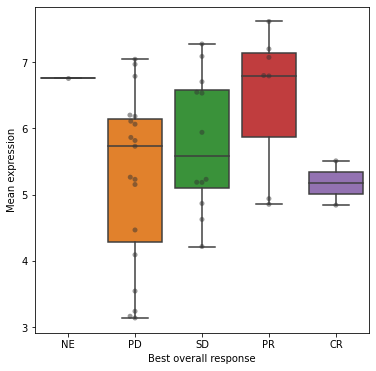

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)

sns.boxplot(x="BOR", 
            y="Score", data=data, 
            order=["NE", "PD", "SD", "PR", "CR"], 
            fliersize=0, ax=ax)
sns.swarmplot(x="BOR", 
              y="Score", 
              data=data, 
              order=["NE", "PD", "SD", "PR", "CR"], 
              color=".2", alpha=0.5, ax=ax)
ax.set_ylabel("Mean expression")
ax.set_xlabel("Best overall response")

In [94]:
mat = data[["PatientID", "PFS", "PFS_SOR", "Score"]].copy()
# PFS_SOR indicates whether the time to event has been censored
# so we need to do 1 - PFS_SOR to get the event indicator
mat["pfs_event"] = 1 - mat["PFS_SOR"]
mat.drop("PFS_SOR", axis=1, inplace=True)
mat.set_index("PatientID", inplace=True)
mat.head(2)

,PFS,Score,pfs_event
PatientID,,,
pt1,54,6.967647,1
pt10,119,4.217360,1


In [95]:
cph = CoxPHFitter()
cph.fit(df=mat, duration_col='PFS', 
        event_col='pfs_event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Score,-0.331749,0.717668,0.158429,-0.642263,-0.021234,0.5261,0.978989,0.0,-2.093996,0.03626,4.785462


<AxesSubplot:xlabel='timeline'>

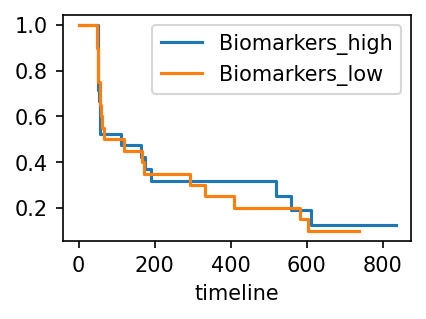

In [97]:
kmf = KaplanMeierFitter()

fig, ax = plt.subplots(dpi=150, figsize=(3, 2))

high_idx = mat.Score >= mat.Score.median()

kmf.fit(mat.PFS[high_idx], mat.pfs_event[high_idx],
        label="Biomarkers_high")
kmf.plot(ax=ax, ci_show=False)
kmf.fit(mat.PFS[~high_idx], mat.pfs_event[~high_idx],
        label="Biomarkers_low")
kmf.plot(ax=ax, ci_show=False)